In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

results = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/lab-evaluation-data.csv')
results.head()

,actual,prob
0,0.0,0.380052
1,1.0,0.827923
2,1.0,0.929093
3,1.0,0.472508
4,1.0,0.906988


## Q1
### Determine the distribution of the actual event.
### Would you be concerned about bias due to imbalance?

In [190]:

results['actual'].value_counts()

1.0    3000
0.0    2000
Name: actual, dtype: int64

### Here the number of examples in the training dataset for each class label is not balanced, there is slight imbalance as the data  in the ratio 3:2. It is not a severe imbalance. model may be biased towards majority class which is true class in this dataset but chance of bias are vey less as it is not severe imbalance 

### Q2 Create a histogram that shows the distribution of the probabilities for the True and False classes.
### Describe what you observe.

In [191]:
true_cls = results[results['actual'] == 1.0]
false_cls = results[results['actual'] == 0.0]

(array([ 89., 194., 346., 352., 324., 242., 208., 134.,  77.,  34.]),
 array([0.00482399, 0.07348497, 0.14214595, 0.21080693, 0.27946791,
        0.34812889, 0.41678987, 0.48545084, 0.55411182, 0.6227728 ,
        0.69143378]),
 <BarContainer object of 10 artists>)

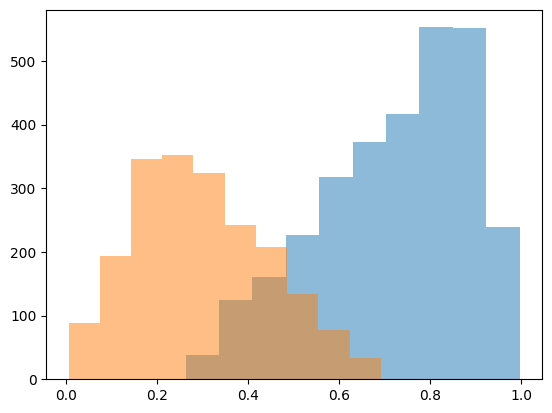

In [192]:

import matplotlib.pyplot as plt
plt.hist(true_cls['prob'], alpha = 0.5)
plt.hist(false_cls['prob'],alpha = 0.5)

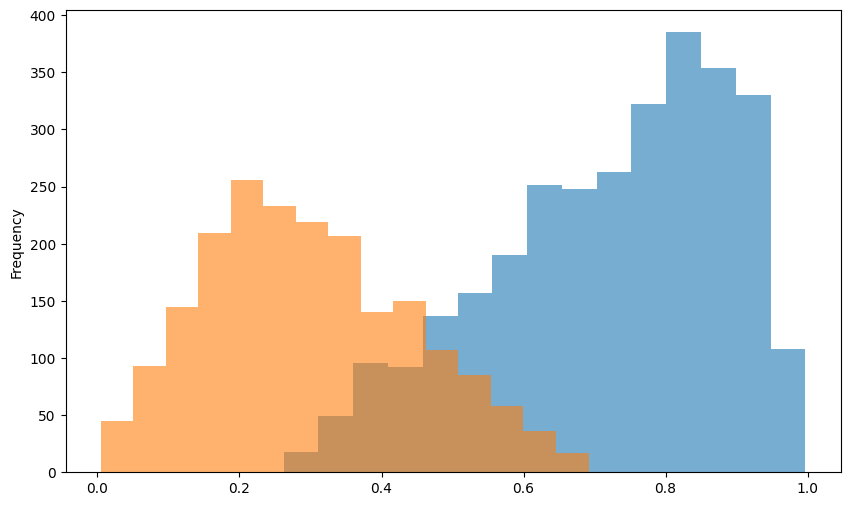

In [193]:
results[results['actual'] == 1.0]['prob'].plot.hist(bins = 15, figsize=(10,6), alpha = 0.6)
results[results['actual'] == 0.0]['prob'].plot.hist(bins = 15, figsize=(10,6), alpha = 0.6)
plt.show()

### Q3
### Create a simple confusion matrix. Use 0.5 as the threshold for whether an observation should be considered True or False.
### Comment on what you observe.

In [195]:
results['y_pred'] = np.where(results['prob'] >= 0.5, float(1), float(0))
y_pred1 =  results['y_pred']

In [196]:
print(results['y_pred'])

0       0.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
4995    0.0
4996    1.0
4997    1.0
4998    0.0
4999    1.0
Name: y_pred, Length: 5000, dtype: float64


In [197]:
def comp_confmatrix(actual, predicted):

    # extract the different classes
    classes = np.unique(actual)
    # classes = classes[::-1] ### this is to get true positives at the top left column

    conf_mat = np.zeros((len(classes), len(classes)))

    # loop across the different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):

           # count the number of instances in each combination of actual / predicted classes
           conf_mat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return conf_mat

cmat = comp_confmatrix(results['actual'], results['y_pred'])
print(cmat)

### confusion matrix for actual on left side (y-axis) and prediction on top side(x-axis) since we have binary values(0,1) . 0 comes first and 1 comes next
###[[TN, FP]
### [FN, TP]]

[[1790.  210.]
 [ 377. 2623.]]


#### True positives and true negatives are more compared to false positives(210) and false negatives(377). Hence this model is performing significantly better

### Q4
### Calculate the accuracy, precision, and recall without using any pre-built functions.
### Which measure would you use if this was your model and why?

##### showing precision, accuaracy, recall for positive class(1)

In [198]:

def mymetrics(cmat): 
    tp = cmat[1][1] 
    fp = cmat[0][1] 
    fn = cmat[1][0] 
    tn = cmat[1][1] 
    return (tp+tn)/(fp+fn+tp+tn), tp/(tp+fp), tp/(tp+fn)
acc, precision, recall = mymetrics(cmat)


In [199]:
precision

0.9258736321920226

In [200]:
acc

0.8993656780387451

In [201]:
recall

0.8743333333333333

In [202]:
def get_metrics(df):

    tp = ((df['actual'] == 1.0 ) & (df['y_pred'] == 1)).sum()
    fp = ((df['actual'] == 0.0 ) & (df['y_pred'] == 1)).sum()
    tn = ((df['actual'] == 0.0 ) & (df['y_pred'] == 0)).sum()
    fn = ((df['actual'] == 1.0 ) & (df['y_pred'] == 0)).sum()
    precision = tp/(tp+fp)
    acc = (tp+tn)/(tp+fp+tn+fn)
    recall = tp/(tp+fn)

    return acc,precision, recall

acc, precision, recall  = get_metrics(results)
print(acc, precision, recall)

0.8826 0.9258736321920226 0.8743333333333333


#### I would use accuracy as the best measure . Since we dont know which one out of FP or FN have significant bad consequences, so cannot decide between precision and recall.so we dont know which one to reduce (FP or FN). Hence accuracy is the perfect measure to consider.

### Q5
### Construct a ROC curve plot.
### Comment on the fit of the model based on this chart.

In [203]:
def get_tpr_fpr(df):

    tp = ((df['actual'] == 1.0 ) & (df['y_pred'] == 1)).sum()
    fp = ((df['actual'] == 0.0 ) & (df['y_pred'] == 1)).sum()
    tn = ((df['actual'] == 0.0 ) & (df['y_pred'] == 0)).sum()
    fn = ((df['actual'] == 1.0 ) & (df['y_pred'] == 0)).sum()
    tpr = tp / (tp + fn )
    fpr = fp / (fp + tn)

    return [tpr, fpr]

tpr, fpr  = get_tpr_fpr(results)
print(tpr,fpr)

0.8743333333333333 0.105


In [204]:
def calculate_thresholds_tpr_fpr_arr(df_original):
    tpr_arr_for_all_thresholds = []
    fpr_arr_for_all_thresholds = []

    sorted_df = df_original.sort_values(by=['prob'], ascending=False)
    unique_thresholds = sorted_df['prob'].unique()

    for threshold in unique_thresholds:
        sorted_df['y_pred'] = np.where(sorted_df['prob'] >= threshold, 1, 0)
        tpr_fpr_arr = get_tpr_fpr(sorted_df)
        tpr_arr_for_all_thresholds.append(tpr_fpr_arr[0])
        fpr_arr_for_all_thresholds.append(tpr_fpr_arr[1])

    return tpr_arr_for_all_thresholds, fpr_arr_for_all_thresholds

tpr_arr_for_all_thresholds, fpr_arr_for_all_thresholds = calculate_thresholds_tpr_fpr_arr(results)

Text(0, 0.5, 'TPR')

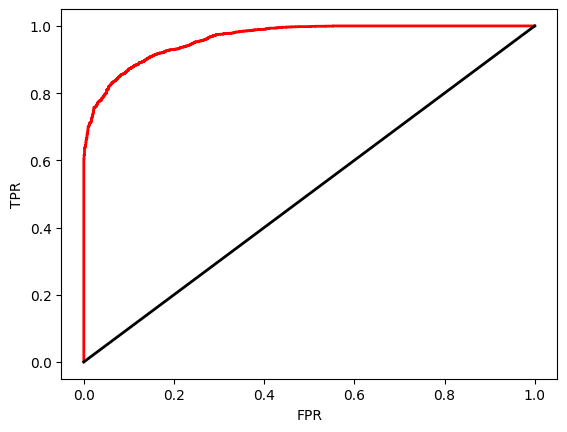

In [205]:
plt.plot(fpr_arr_for_all_thresholds,tpr_arr_for_all_thresholds, 'r', lw=2)
plt.plot([0, 1], [0, 1], 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')

####  It clearly indicate that this fit of the model has got the best performance as we know that Classifiers that give curves closer to the top-left corner indicate a better performance.  The closer the  curve to the top left, more acccurate the model is. we can chose the optimal threshold from this plot based on whether we want to increase tpr and decrease fpr or increase both. tradeoff between tpr and fpr is very important to choose the optimal threshold.